In [105]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

from torchvision.models import resnet34

from tensorboardX import SummaryWriter
writer = SummaryWriter()

import os
import time
import matplotlib.pyplot as plt

# 모델 불러오기

In [106]:
model = resnet34(pretrained = False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:
model.fc = nn.Linear(512, 3, bias=True)
model.load_state_dict(torch.load("C:\Potenup\DeepLearning-Study\src\models\celebrity_image_resnet34_model.pth", map_location='cpu'))

<All keys matched successfully>

In [108]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD)
])

In [109]:
from PIL import Image

image_path = "images/마동석_test_3.png"
image = Image.open(image_path)
image = transforms_test(image).unsqueeze(0)
image.shape

torch.Size([1, 3, 224, 224])

In [110]:
preds = model(image)
print(preds)
pred = torch.max(preds, dim=1)[1]
pred

tensor([[-1.0233,  0.3623, -1.0229]], grad_fn=<AddmmBackward0>)


tensor([1])

# CAM (Class Activation Map)

In [111]:
layer = model.layer4[2].conv2
targets = [ClassifierOutputTarget(0)]
layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# GradCAM 방식

In [112]:
cam = GradCAM(model = model, target_layers=[layer])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=image, targets = targets)
grayscale_cam = grayscale_cam[0,:1]
grayscale_cam

array([[0.304, 0.304, 0.304, 0.304, 0.304, 0.304, 0.304, 0.304, 0.304,
        0.304, 0.304, 0.304, 0.304, 0.304, 0.304, 0.304, 0.307, 0.314,
        0.321, 0.327, 0.334, 0.341, 0.348, 0.355, 0.362, 0.368, 0.375,
        0.382, 0.389, 0.396, 0.402, 0.409, 0.416, 0.423, 0.430, 0.437,
        0.443, 0.450, 0.457, 0.464, 0.471, 0.477, 0.484, 0.491, 0.498,
        0.505, 0.512, 0.518, 0.523, 0.525, 0.527, 0.529, 0.531, 0.533,
        0.535, 0.537, 0.539, 0.540, 0.542, 0.544, 0.546, 0.548, 0.550,
        0.552, 0.554, 0.556, 0.558, 0.560, 0.562, 0.564, 0.566, 0.568,
        0.570, 0.572, 0.574, 0.576, 0.578, 0.580, 0.582, 0.584, 0.585,
        0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585,
        0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585,
        0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585,
        0.585, 0.585, 0.585, 0.585, 0.584, 0.580, 0.577, 0.573, 0.570,
        0.566, 0.563, 0.559, 0.556, 0.553, 0.549, 0.546, 0.542, 0.539,
      

In [113]:
grayscale_cam.max()

np.float32(0.59596616)

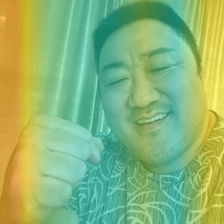

In [114]:
filter_image = Image.open(image_path)
filter_image = filter_image.resize((224, 224))
rgb_image = np.float32(filter_image) / 255
result_grad_cam = show_cam_on_image(rgb_image, grayscale_cam)
display(Image.fromarray(result_grad_cam))

# AblationCAM 방식

In [115]:
cam = AblationCAM(model=model, target_layers=[layer])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=image, targets = targets)
grayscale_cam = grayscale_cam[0,:1]

100%|██████████| 512/512 [00:15<00:00, 32.97it/s]


In [116]:
grayscale_cam.max()

np.float32(0.48562846)

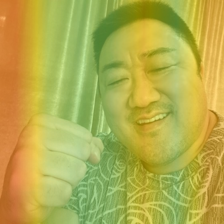

In [117]:
filter_image = Image.open(image_path)
filter_image = filter_image.resize((224, 224))
rgb_image = np.float32(filter_image) / 255
result_grad_cam = show_cam_on_image(rgb_image, grayscale_cam)
display(Image.fromarray(result_grad_cam))